In [22]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime

In [23]:
# Define the stock symbol and date range
stock_symbol = 'AAPL'
start_date = '2014-01-01'
end_date = datetime.now()

In [24]:
# Get the stock quote
df = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


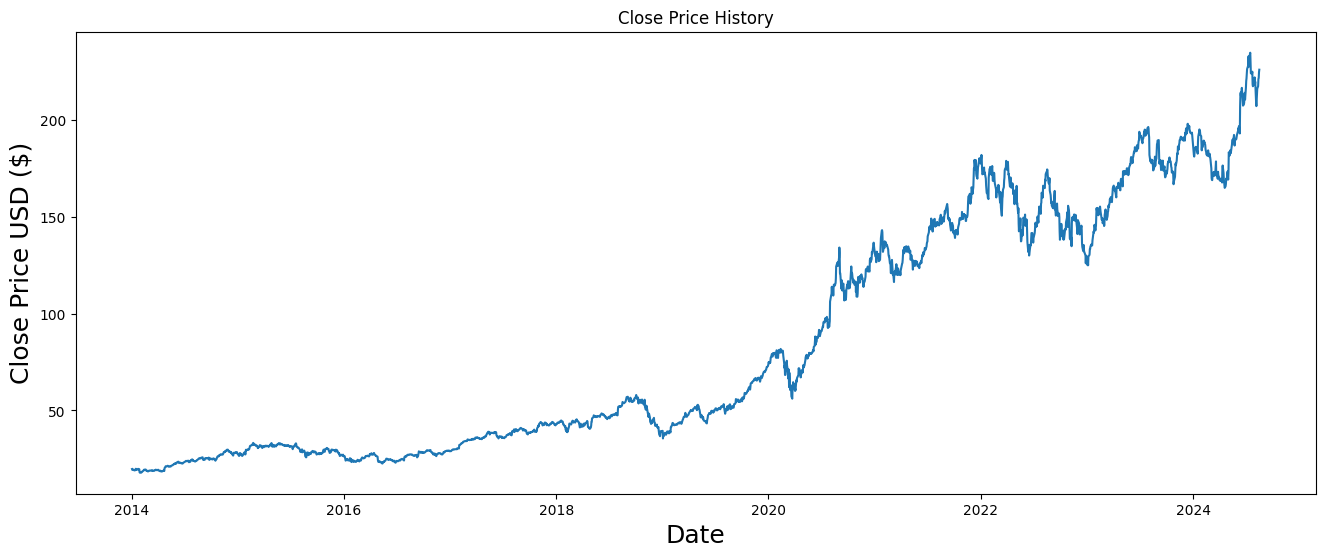

In [25]:
# Show the data
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [26]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
dataset = data.values

In [27]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * 0.95))
print(f"Training data length: {training_data_len}")

Training data length: 2541


In [28]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [29]:
# Create the training data set
train_data = scaled_data[:training_data_len, :]
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)   

In [30]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [31]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


C:\Program Files\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)  # Increased epochs for better training

Epoch 1/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - loss: 0.0046
Epoch 2/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 4.3796e-04
Epoch 3/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 3.0852e-04
Epoch 4/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 3.4633e-04
Epoch 5/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - loss: 2.7954e-04
Epoch 6/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 2.3143e-04
Epoch 7/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - loss: 2.3367e-04
Epoch 8/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - loss: 2.2216e-04
Epoch 9/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - loss: 1.7366e-04
Epoch 10/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 1.8293e-04


In [34]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [35]:
# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


In [36]:
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"RMSE: {rmse}")

RMSE: 13.325195062983525


C:\Users\Manoj\AppData\Local\Temp\ipykernel_6928\2770638779.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


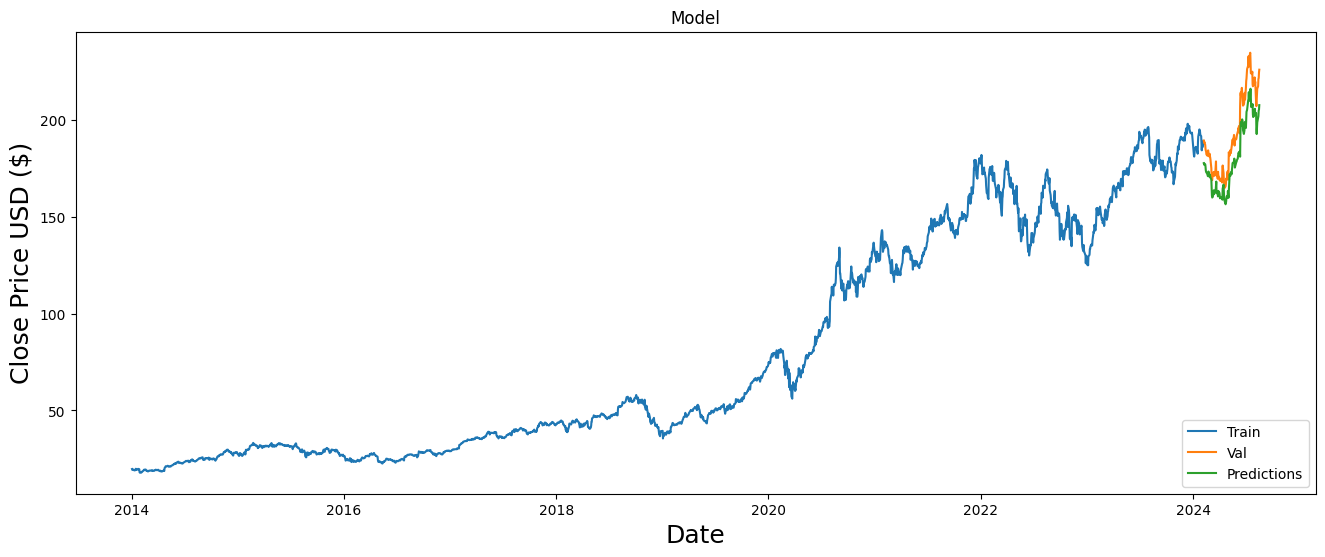

In [37]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [38]:
# Show the valid and predicted prices
print(valid)


                 Close  Predictions
Date                               
2024-02-07  189.410004   177.789032
2024-02-08  188.320007   177.893478
2024-02-09  188.850006   176.857254
2024-02-12  187.149994   177.166473
2024-02-13  185.039993   175.892197
...                ...          ...
2024-08-12  217.529999   201.225357
2024-08-13  221.270004   202.066010
2024-08-14  221.720001   204.974442
2024-08-15  224.720001   205.400177
2024-08-16  226.050003   207.739304

[133 rows x 2 columns]
